In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy
import cartopy.crs as ccrs
import atlite
import rasterio
import pypsa
import os
import yaml
import re
import seaborn as sns
import matplotlib as mpl

import matplotlib.animation as animation
from matplotlib.colors import ListedColormap

with open('../pypsa-earth/config.SEA_base.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [10]:
import warnings
warnings.filterwarnings("ignore")

country_longname = {
    "MM": "Myanmar",
    "TH": "Thailand",
    "LA": "Laos",
    "SG": "Singapore",
    "KH": "Cambodia",
    "VN": "Vietnam",
    "BN": "Brunei",
    "PH": "Philippines",
    "Peninsular/MY": "Malay Peninsular (M)",
    "Sumatra/ID": "Sumatra (I)",
    "Java-Bali/ID": "Java-Bali (I)",
    "Sarawak/MY":  "Sarawak (M)",
    "Kalimantan/ID": "Kalimantan (I)",
    "Sabah/MY": "Sabah (M)",
    "Nusa-Tenggara/ID": "Nusa-Tenggara (I)",
    "Sulawesi/ID": "Sulawesi (I)",
    "Maluku/ID": "Maluku (I)",
    "Papua/ID": "West Papua (I)"
    }

country_prefered_order = ['Nusa-Tenggara (I)', 'Java-Bali (I)', 'West Papua (I)', 'Maluku (I)',
                           'Sulawesi (I)', 'Sumatra (I)', 'Kalimantan (I)', 'Singapore',
                           'Sarawak (M)', 'Malay Peninsular (M)', 'Brunei', 'Sabah (M)',
                           'Philippines', 'Cambodia', 'Thailand', 'Vietnam', 'Laos', 'Myanmar']

In [48]:
def decide_ppl(df_def):
    
    df_base = df_def.copy(deep=True)
    for year in df_base.columns:
        df_base[year] = df_base[year].apply(lambda x: np.nan if np.isnan(x) else (0 if x < 20 else (1 if x < 40 else 2)))

    df_hatch = df_base.copy(deep=True)
    df_nan = df_base.copy(deep=True)

    year_counter = 0
    for year in [2020,2025,2030,2035,2040,2045,2050]:
        df_hatch[year] = df_base.T[year_counter:].max()
        for i in df_base.index:
            if np.isnan(df_base.loc[i,year]):
                df_hatch.loc[i,year] = np.nan

        year_counter += 1

    moth_bool = np.ma.masked_not_equal(df_hatch.values, 2)
    phase_bool = np.ma.masked_not_equal(df_hatch.values, 1)

    return df_base, moth_bool, phase_bool

def capacity_factor_table(fn, scenario_PyPSA, dec_name):
    pd.set_option('display.max_rows', None)

    coal_carrier = ["coal", "coal-SubC","coal-CFB", "coal-SC", "coal-USC", "lignite"]
    
    for year in years:
        n = fn[year]
        
        df_gen = n.generators
        df_gen["country"] = n.generators.bus.map(n.buses.country)
        df_gen["p"] = n.snapshot_weightings.generators @ n.generators_t.p
        df_gen = df_gen.groupby(["carrier","country"])[["p_nom_opt","p"]].sum()
        df_gen["cap_factor"] = df_gen["p"] / (8760 * df_gen["p_nom_opt"])*100
        
        df_gen = df_gen.loc[(df_gen.index.get_level_values('carrier').isin(coal_carrier))]
    
        if year == 2020:
            df_cap_factor = df_gen.rename(columns={"cap_factor":2020}).loc[:,2020]
            df_cap_factor = df_cap_factor
        else:
            df_cap_factor = pd.concat([df_cap_factor,df_gen.rename(columns={"cap_factor":year}).loc[:,year]], axis=1)

    
    df_cap_factor = df_cap_factor.reset_index()
    df_cap_factor["country"] =  [country_longname[c] for c in df_cap_factor.country]

    height_ratio = []
    for c in coal_carrier:
        height_ratio += [len(df_cap_factor.query("carrier == @c"))]

    fig, ax = plt.subplots(len(coal_carrier), 2, figsize=(8,15), facecolor='w', edgecolor='k', gridspec_kw={'height_ratios': height_ratio})
    plt.subplots_adjust(wspace=0.15, hspace=0.05)
    mpl.rc('hatch', color='k', linewidth=2)

    c_num = 0
    for c in coal_carrier:
        df_carrier = df_cap_factor.query("carrier == @c")
        df_carrier = df_carrier.drop(columns=['carrier'])
        df_carrier = df_carrier.rename(columns={"country":c})
        df_carrier = df_carrier.set_index(c)
        new_index_order = [c for c in reversed(country_prefered_order) if c in df_carrier.index]
        df_carrier = df_carrier.loc[new_index_order,:]
        #display(df_carrier)

        if c_num == len(coal_carrier) - 1:
            xticklabels = True
        else:
            xticklabels = False

        sns.heatmap(df_carrier, vmin=0, vmax=100, annot=True, cmap='inferno', cbar=False, ax=ax[c_num,0], xticklabels=xticklabels, fmt='.1f')
        ax[c_num,0].set_yticklabels(ax[c_num,0].get_yticklabels(), rotation=0)
        ax[c_num,0].set_ylabel(None)

        df_decide, moth_bool, phase_bool = decide_ppl(df_carrier)
        
        sns.heatmap(df_decide, vmin=0, vmax=2, annot=False, cmap='viridis', cbar=False, ax=ax[c_num,1], xticklabels=xticklabels, yticklabels=False)

        zm = np.ma.masked_less(df_carrier.values, 50)
        x= np.arange(len(df_carrier.columns)+1)
        y= np.arange(len(df_carrier.index)+1)

        none_map = ListedColormap(['none'])

        ax[c_num,1].pcolor(x, y, phase_bool, hatch='////', edgecolors = "#21918c", lw=0, zorder=1, cmap=none_map)
        ax[c_num,1].pcolor(x, y, moth_bool, hatch='////', edgecolors = "#fce624", lw=0, zorder=2, cmap=none_map)
        c_num += 1

    d = {'label': ["Phase-Out", "Phase-Down", "Constant", "Mothball", "Mothball & Phase-Down"], 
         'color': ["#440154", "#21918c", "#fce624", "none", "none"],
         'hatch': ["/","/","/","////","////"],
         'edgecolor': ["none", "none", "none", "#fce624", "#21918c"]
        }
    
    df_legend = pd.DataFrame(d, index=d['label'])
    
    pypsa.plot.add_legend_patches(ax=ax[5,0], colors = df_legend.color, labels = df_legend.index,
                                  legend_kw = {'loc':"upper center",'bbox_to_anchor':(1, -0.1), 'frameon':False, 'ncol':5, 'title':"Power Plant Operation Policy", 
                                              'title_fontproperties':{'weight':'bold'}})
    
    pypsa.plot.add_legend_patches(ax=ax[5,0], colors = "#21918c", labels = "",
                                  patch_kw = {'hatch':"////", 'edgecolor':"#fce624",'lw':0},
                                  legend_kw = {'loc':"upper center",'bbox_to_anchor':(1.22, -0.08), 'frameon':False, 'title':" ", 
                                              'title_fontproperties':{'weight':'bold'}})
    
    pypsa.plot.add_legend_patches(ax=ax[5,0], colors = "#440154", labels = "",
                                  patch_kw = {'hatch':"////", 'edgecolor':"#fce624",'lw':0},
                                  legend_kw = {'loc':"upper center",'bbox_to_anchor':(1.22, -0.12), 'frameon':False, 'title':" ", 
                                              'title_fontproperties':{'weight':'bold'}})

    pypsa.plot.add_legend_patches(ax=ax[5,0], colors = "#440154", labels = "",
                                  patch_kw = {'hatch':"////", 'edgecolor':"#21918c",'lw':0},
                                  legend_kw = {'loc':"upper center",'bbox_to_anchor':(1.65, -0.1), 'frameon':False, 'title':" ", 
                                              'title_fontproperties':{'weight':'bold'}})

    mpl.rc('hatch', color='k', linewidth=2)
    pd.set_option('display.max_rows', 10)

    ax[0,0].set_title(f'{scenario_PyPSA}{dec_name}', 
          loc='center', 
          x=0.5, 
          y=1.05,
          fontsize=9
         )

    ax[0,1].set_title(f'{scenario_PyPSA}{dec_name}', 
          loc='center', 
          x=0.5, 
          y=1.05,
          fontsize=9
         )

    if not os.path.exists(f'Figures/{scenario_PyPSA}{dec_name}'):
        os.mkdir(f'Figures/{scenario_PyPSA}{dec_name}')

    plt.savefig(f'Figures/{scenario_PyPSA}{dec_name}/{scenario_PyPSA}{dec_name}_coal_phaseout.svg',bbox_inches='tight')

In [59]:
def capacity_factor_table_compare(fn1, scenario_PyPSA1, dec_name1, fn2, scenario_PyPSA2, dec_name2):
    pd.set_option('display.max_rows', None)

    coal_carrier = ["coal", "coal-SubC","coal-CFB", "coal-SC", "coal-USC", "lignite"]

    height_ratio = [6, 11, 6, 4, 1, 8]

    fig, ax = plt.subplots(len(coal_carrier), 2, figsize=(8,15), facecolor='w', edgecolor='k', gridspec_kw={'height_ratios': height_ratio})
    plt.subplots_adjust(wspace=0.15, hspace=0.05)
    mpl.rc('hatch', color='k', linewidth=2)

    column_num = 0
    yticklabels = True
    for fn in [fn1, fn2]:
        for year in years:
            n = fn[year]
            
            df_gen = n.generators
            df_gen["country"] = n.generators.bus.map(n.buses.country)
            df_gen["p"] = n.snapshot_weightings.generators @ n.generators_t.p
            df_gen = df_gen.groupby(["carrier","country"])[["p_nom_opt","p"]].sum()
            df_gen["cap_factor"] = df_gen["p"] / (8760 * df_gen["p_nom_opt"])*100
            
            df_gen = df_gen.loc[(df_gen.index.get_level_values('carrier').isin(coal_carrier))]
        
            if year == 2020:
                df_cap_factor = df_gen.rename(columns={"cap_factor":2020}).loc[:,2020]
                df_cap_factor = df_cap_factor
            else:
                df_cap_factor = pd.concat([df_cap_factor,df_gen.rename(columns={"cap_factor":year}).loc[:,year]], axis=1)
    
        
        df_cap_factor = df_cap_factor.reset_index()
        df_cap_factor["country"] =  [country_longname[c] for c in df_cap_factor.country]

        c_num = 0
        
        for c in coal_carrier:
            df_carrier = df_cap_factor.query("carrier == @c")
            df_carrier = df_carrier.drop(columns=['carrier'])
            df_carrier = df_carrier.rename(columns={"country":c})
            df_carrier = df_carrier.set_index(c)
            new_index_order = [c for c in reversed(country_prefered_order) if c in df_carrier.index]
            df_carrier = df_carrier.loc[new_index_order,:]
            #display(df_carrier)
    
            if c_num == len(coal_carrier) - 1:
                xticklabels = True
            else:
                xticklabels = False

                        
    
            df_decide, moth_bool, phase_bool = decide_ppl(df_carrier)
            
            sns.heatmap(df_decide, vmin=0, vmax=2, annot=False, cmap='viridis', cbar=False, ax=ax[c_num,column_num], xticklabels=xticklabels, yticklabels=yticklabels)
    
            zm = np.ma.masked_less(df_carrier.values, 50)
            x= np.arange(len(df_carrier.columns)+1)
            y= np.arange(len(df_carrier.index)+1)
    
            none_map = ListedColormap(['none'])
    
            ax[c_num,column_num].pcolor(x, y, phase_bool, hatch='////', edgecolors = "#21918c", lw=0, zorder=1, cmap=none_map)
            ax[c_num,column_num].pcolor(x, y, moth_bool, hatch='////', edgecolors = "#fce624", lw=0, zorder=2, cmap=none_map)

            ax[c_num,0].set_yticklabels(ax[c_num,0].get_yticklabels(), rotation=0)
            ax[c_num,0].set_ylabel(None)
            c_num += 1

        column_num = 1
        yticklabels = False

    d = {'label': ["Phase-Out", "Phase-Down", "Constant", "Mothball", "Mothball & Phase-Down"], 
         'color': ["#440154", "#21918c", "#fce624", "none", "none"],
         'hatch': ["/","/","/","////","////"],
         'edgecolor': ["none", "none", "none", "#fce624", "#21918c"]
        }
    
    df_legend = pd.DataFrame(d, index=d['label'])
    
    pypsa.plot.add_legend_patches(ax=ax[5,0], colors = df_legend.color, labels = df_legend.index,
                                  legend_kw = {'loc':"upper center",'bbox_to_anchor':(1, -0.1), 'frameon':False, 'ncol':5, 'title':"Power Plant Operation Policy", 
                                              'title_fontproperties':{'weight':'bold'}})
    
    pypsa.plot.add_legend_patches(ax=ax[5,0], colors = "#21918c", labels = "",
                                  patch_kw = {'hatch':"////", 'edgecolor':"#fce624",'lw':0},
                                  legend_kw = {'loc':"upper center",'bbox_to_anchor':(1.22, -0.08), 'frameon':False, 'title':" ", 
                                              'title_fontproperties':{'weight':'bold'}})
    
    pypsa.plot.add_legend_patches(ax=ax[5,0], colors = "#440154", labels = "",
                                  patch_kw = {'hatch':"////", 'edgecolor':"#fce624",'lw':0},
                                  legend_kw = {'loc':"upper center",'bbox_to_anchor':(1.22, -0.12), 'frameon':False, 'title':" ", 
                                              'title_fontproperties':{'weight':'bold'}})

    pypsa.plot.add_legend_patches(ax=ax[5,0], colors = "#440154", labels = "",
                                  patch_kw = {'hatch':"////", 'edgecolor':"#21918c",'lw':0},
                                  legend_kw = {'loc':"upper center",'bbox_to_anchor':(1.65, -0.1), 'frameon':False, 'title':" ", 
                                              'title_fontproperties':{'weight':'bold'}})

    mpl.rc('hatch', color='k', linewidth=2)
    pd.set_option('display.max_rows', 10)

    ax[0,0].set_title(f'{scenario_PyPSA1}{dec_name1}', 
          loc='center', 
          x=0.5, 
          y=1.05,
          fontsize=9
         )

    ax[0,1].set_title(f'{scenario_PyPSA2}{dec_name2}', 
          loc='center', 
          x=0.5, 
          y=1.05,
          fontsize=9
         )

    if not os.path.exists(f'Figures/{scenario_PyPSA2}{dec_name2}'):
        os.mkdir(f'Figures/{scenario_PyPSA2}{dec_name2}')

    plt.savefig(f'Figures/{scenario_PyPSA2}{dec_name2}/{scenario_PyPSA2}{dec_name2}_coal_phaseout_validate.svg',bbox_inches='tight')

## Unused Code

In [56]:
def plot_cap_factor(n):
    cap_factor = pd.DataFrame()
    
    for year in years:
        stats = n.statistics()
        cap_factor[year] = stats['Capacity Factor']
    
    cap_factor = cap_factor.groupby(cap_factor.index.get_level_values(1)).sum()
    
    cap_factor.loc[["Coal", "Coal-Subc", "Coal-Cfb", "Coal-Sc", "Coal-Usc", "Lignite", "Combined-Cycle Gas"],:].T.plot()

In [ ]:
scenario_PyPSA = "SEA_opt_stable_BAU_"
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L0.765839-3H"

year= 2030

n = pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc")

In [10]:
n.generators.query("carrier == 'coal'")

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,bus,p_nom_extendable,carrier,...,sign,marginal_cost_quadratic,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,
Kalimantan/ID7 14 coal,inf,0.0,14.0,358553.127752,0.33,14.0,32.223021,Kalimantan/ID7 14,False,coal,...,1.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
Kalimantan/ID7 5 coal,inf,0.0,100.0,358553.127752,0.33,100.0,32.223973,Kalimantan/ID7 5,False,coal,...,1.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
Sulawesi/ID1 3 coal,inf,0.0,30.0,358553.127752,0.33,30.0,32.223943,Sulawesi/ID1 3,False,coal,...,1.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
Sulawesi/ID1 5 coal,inf,0.0,391.0,358553.127752,0.33,391.0,32.224052,Sulawesi/ID1 5,False,coal,...,1.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
Sulawesi/ID1 6 coal,inf,0.0,345.0,358553.127752,0.33,345.0,32.224109,Sulawesi/ID1 6,False,coal,...,1.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
Sumatra/ID3 14 coal,inf,0.0,1200.0,358553.127752,0.33,1200.0,32.222745,Sumatra/ID3 14,False,coal,...,1.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


# Stagnant Technology

In [28]:
SE_co2_share = {2020:"Co2L1.0-3H",
             2025:"Co2L0.882919-3H",
             2030:"Co2L0.765839-3H",
             2035:"Co2L0.648758-3H",
             2040:"Co2L0.531677-3H",
             2045:"Co2L0.414596-3H",
             2050:"Co2L0.297516-3H"
            }
DEC_co2_share = {2020:"Co2L1.0-3H",
             2025:"Co2L0.750481-3H",
             2030:"Co2L0.536087-3H",
             2035:"Co2L0.356817-3H",
             2040:"Co2L0.212671-3H",
             2045:"Co2L0.103649-3H",
             2050:"Co2L0.029752-3H"
            }

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


[6, 11, 6, 4, 1, 8]

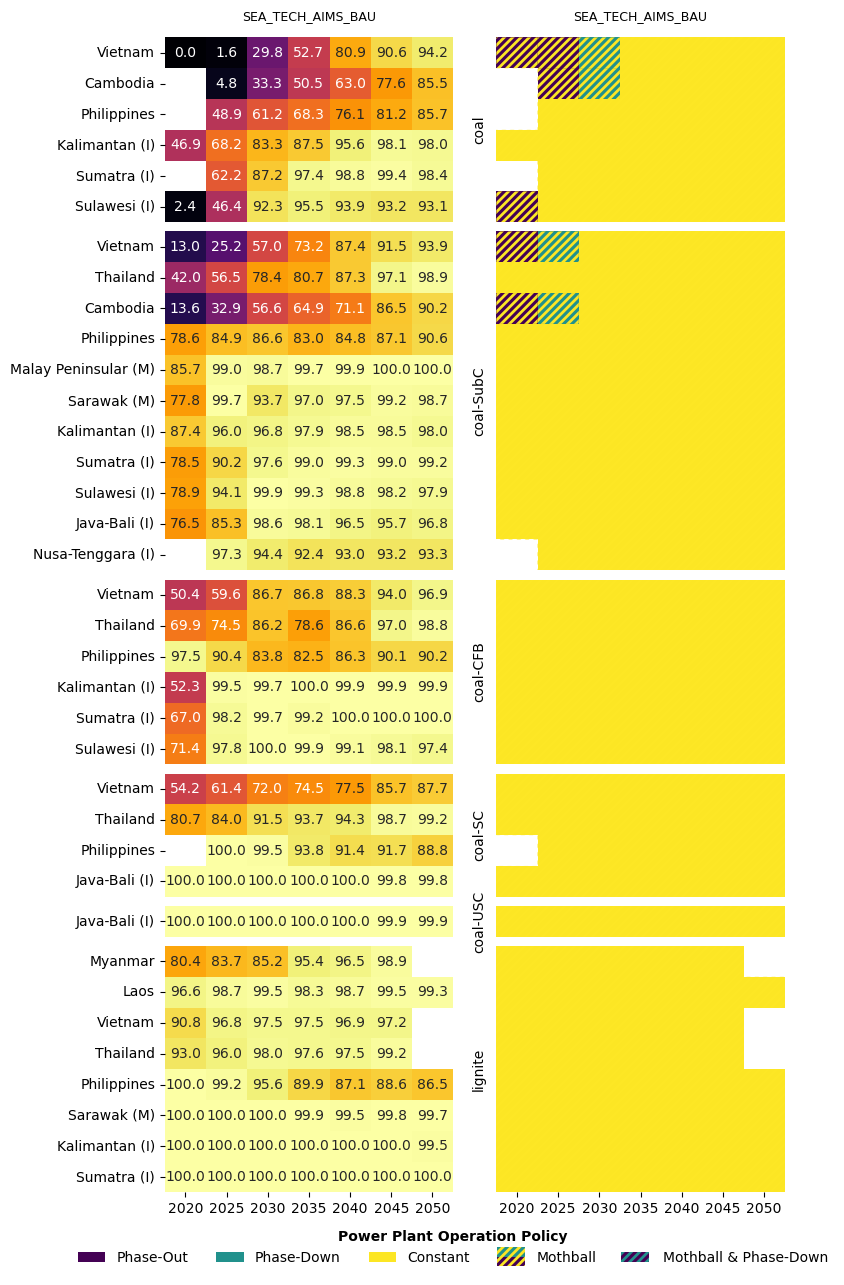

In [47]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth-final_V1"
network_name = "elec_s_200_ec_lcopt_3H"
dec_name = "BAU"

years = [2020,2025,2030,2035,2040,2045,2050]

fn_bau_tech = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years} 

scenario_PyPSA = "SEA_TECH_AIMS_"

capacity_factor_table(fn_bau_tech, scenario_PyPSA, dec_name)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1.0-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.882919-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.765839-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.648758-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.531677-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.414596-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.297516-3H.nc has buses, carriers, generato

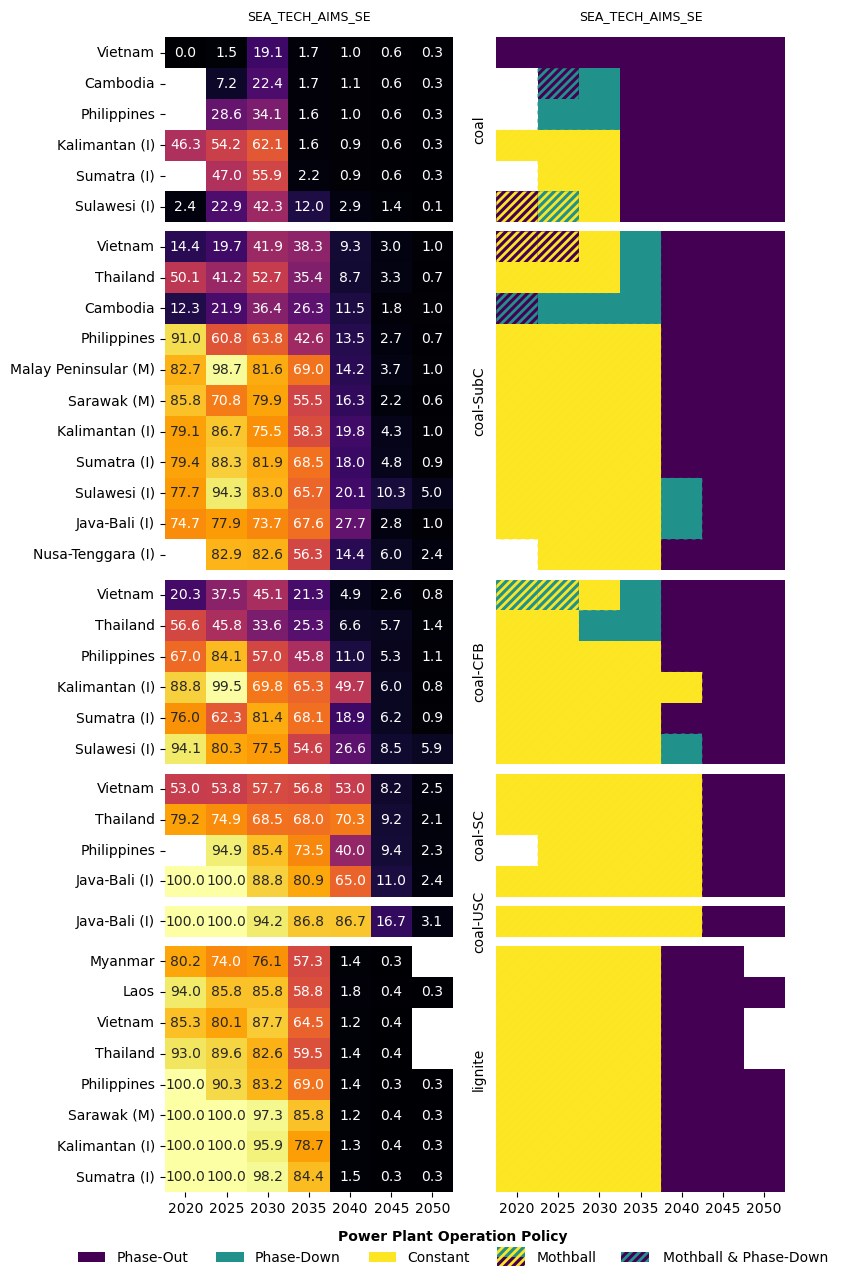

In [31]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth-final_V1"
dec_name = "SE"

co2_share = SE_co2_share

network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

fn_se_tech = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years} 

scenario_PyPSA = "SEA_TECH_AIMS_"

capacity_factor_table(fn_se_tech, scenario_PyPSA, dec_name)

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1.0-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.750481-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.536087-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.356817-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.212671-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.103649-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.029752-3H.nc has buses, carriers, generato

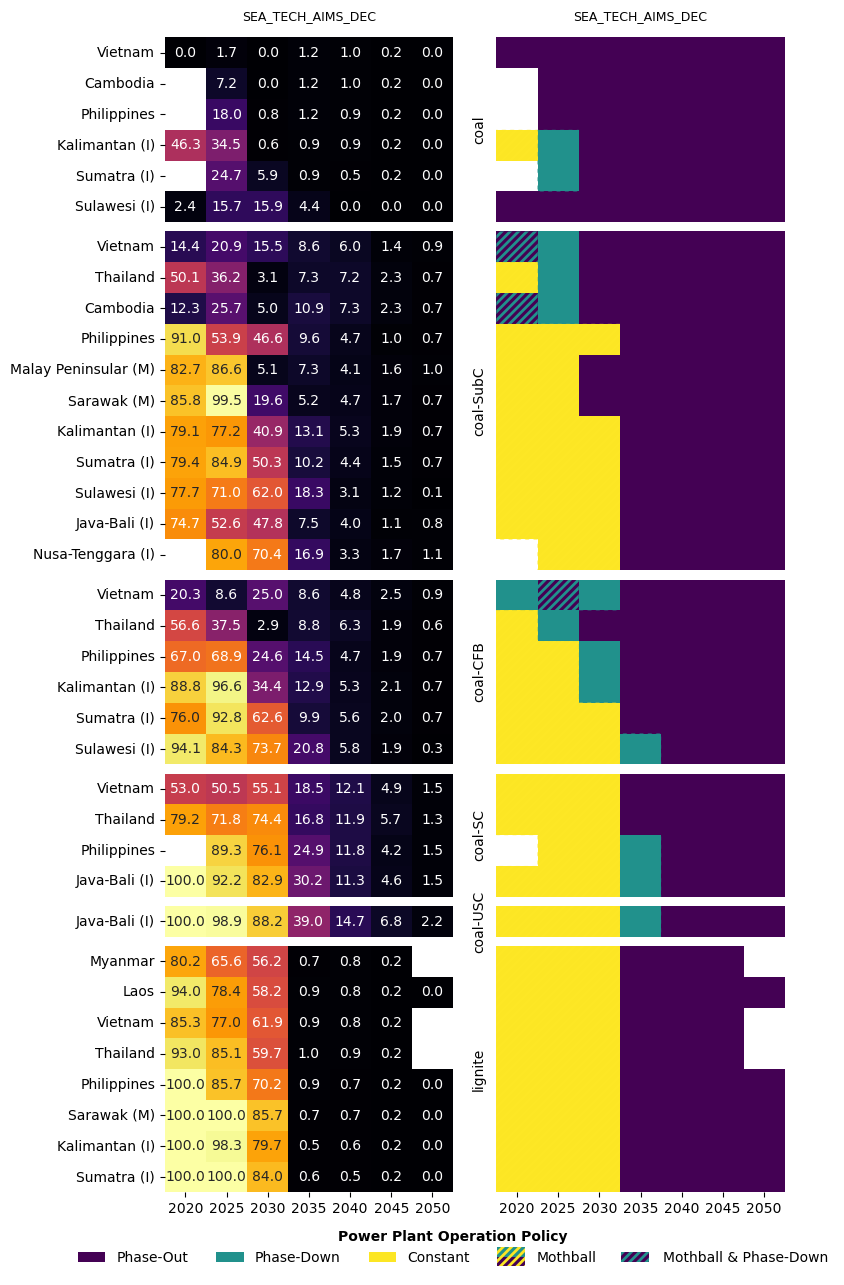

In [32]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth-final_V1"
dec_name = "DEC"

co2_share = DEC_co2_share

network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

fn_dec_tech = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years} 

scenario_PyPSA = "SEA_TECH_AIMS_"

capacity_factor_table(fn_dec_tech, scenario_PyPSA, dec_name)

# Load PyPSA

In [37]:
SE_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.916821-3H",
             2030:"Co2L0.833641-3H",
             2035:"Co2L0.750462-3H",
             2040:"Co2L0.667283-3H",
             2045:"Co2L0.584104-3H",
             2050:"Co2L0.500924-3H"
            }
DEC_co2_share = {2020:"Co2L1-3H",
             2025:"Co2L0.779298-3H",
             2030:"Co2L0.583549-3H",
             2035:"Co2L0.412754-3H",
             2040:"Co2L0.266913-3H",
             2045:"Co2L0.146026-3H",
             2050:"Co2L0.050092-3H"
            }

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_3H.nc has buses, carriers, generators, lines, links, loads, stores


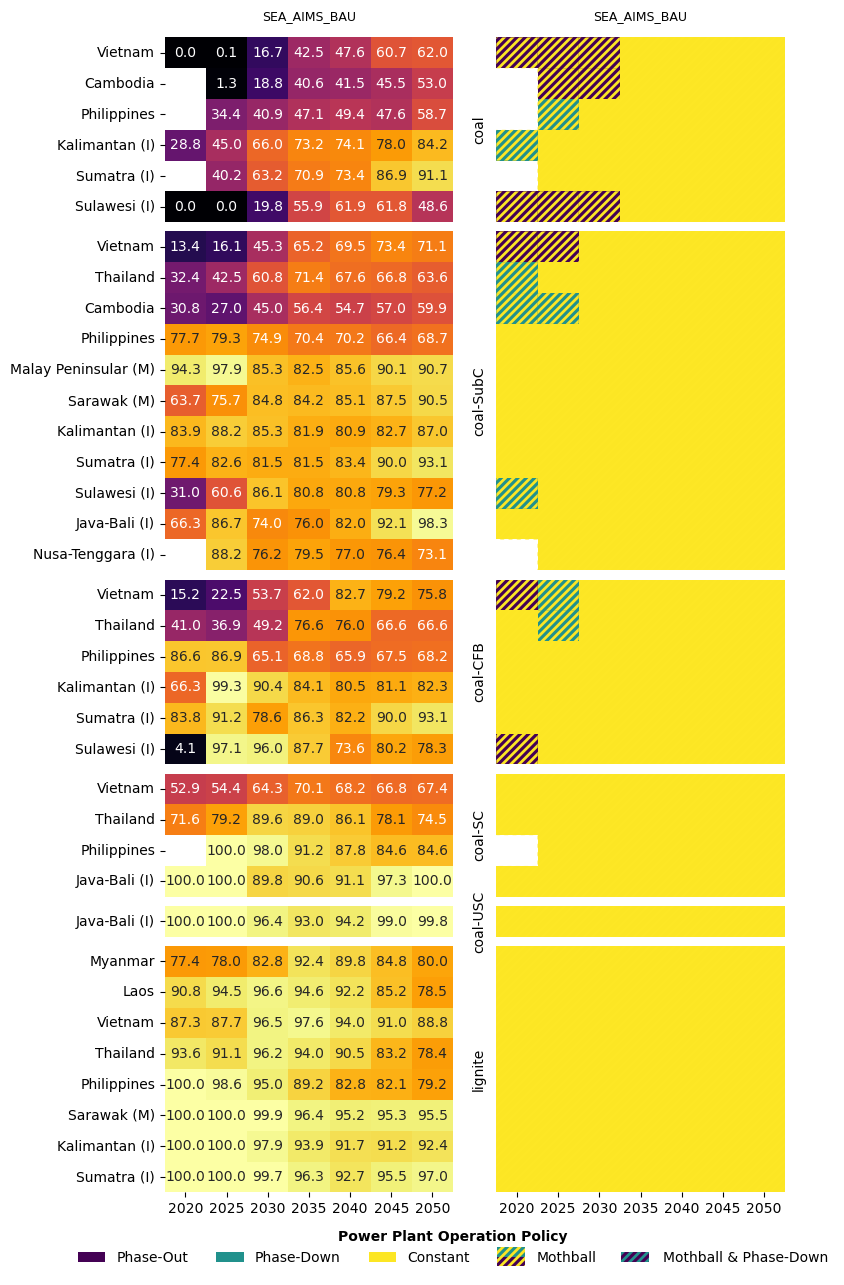

In [38]:
scenario_PyPSA = "SEA_AIMS_"
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_3H"
dec_name = "BAU"

years = [2020,2025,2030,2035,2040,2045,2050]

fn_bau = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}.nc") for year in years} 

capacity_factor_table(fn_bau, scenario_PyPSA, dec_name)

### Stable Emission

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.916821-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.833641-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.750462-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.667283-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.584104-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.500924-3H.nc has buses, carriers, generators

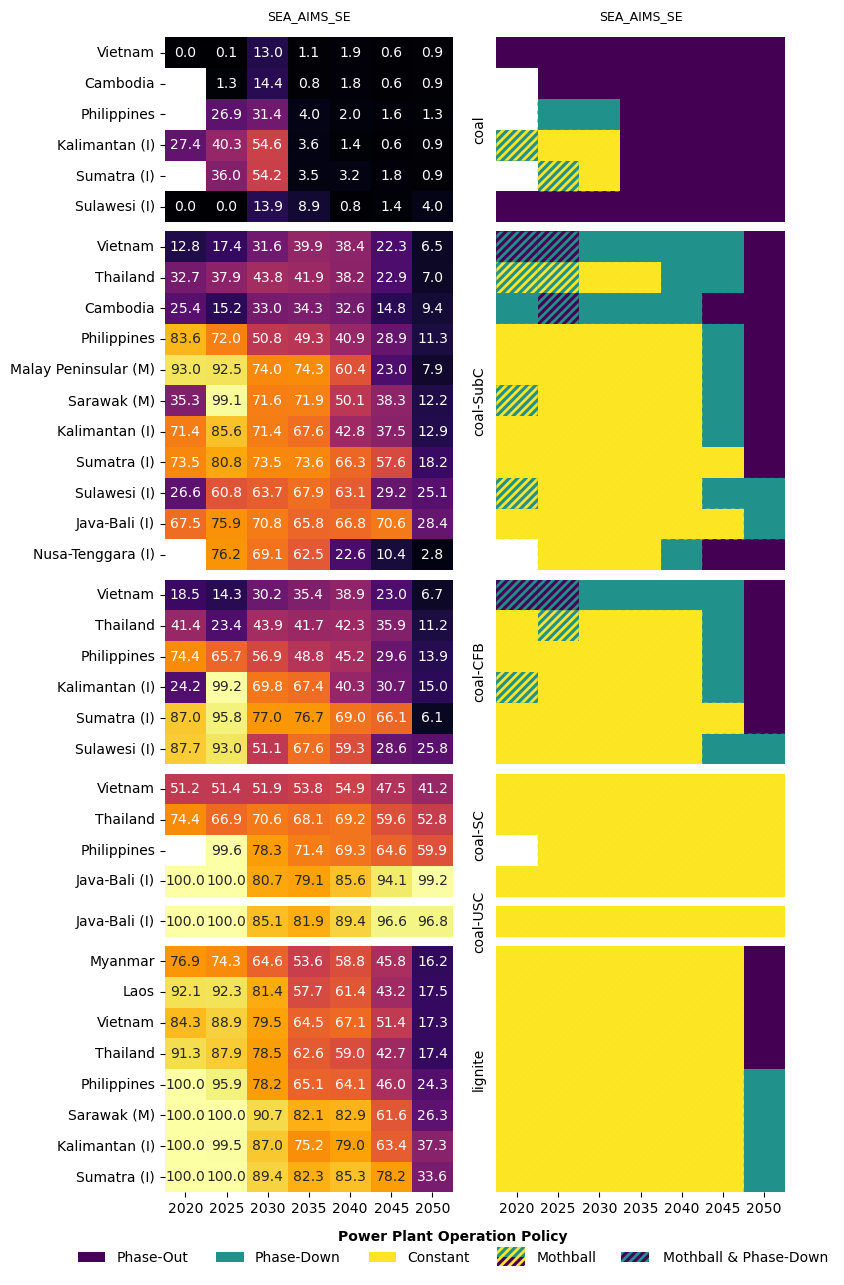

In [39]:
scenario_PyPSA = "SEA_AIMS_"
folder_name = "pypsa-earth"
dec_name = "SE"

co2_share = SE_co2_share

network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

fn_se = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years} 

capacity_factor_table(fn_se, scenario_PyPSA, dec_name)

### Decarbonize

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L1-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.779298-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.583549-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.412754-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.266913-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.146026-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.050092-3H.nc has buses, carriers, generators

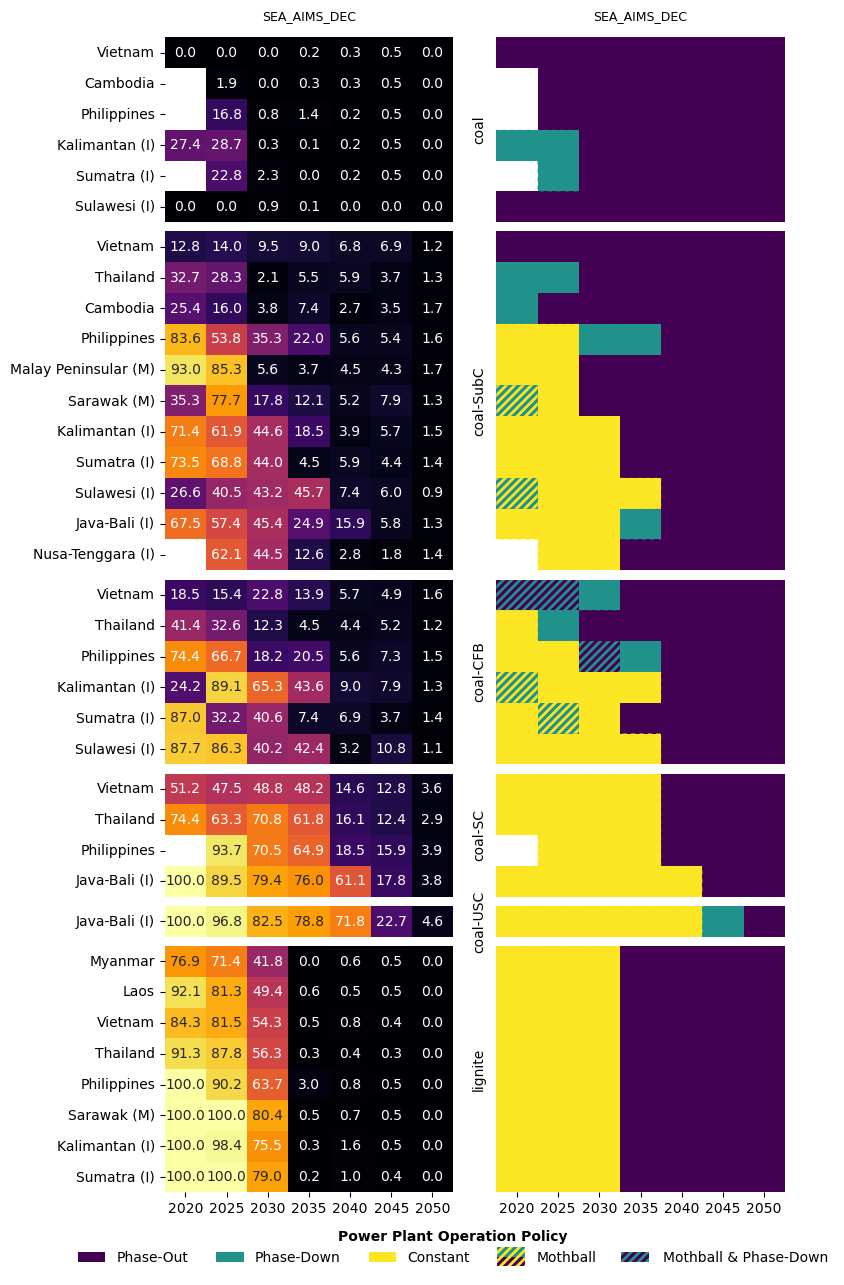

In [40]:
scenario_PyPSA = "SEA_AIMS_"
folder_name = "pypsa-earth"
dec_name = "DEC"

co2_share = DEC_co2_share
network_name = "elec_s_200_ec_lcopt_"

years = [2020,2025,2030,2035,2040,2045,2050]

fn_dec = {year:pypsa.Network(f"../{folder_name}/results/{scenario_PyPSA + str(year)}/networks/{network_name}{co2_share[year]}.nc") for year in years} 

capacity_factor_table(fn_dec, scenario_PyPSA, dec_name)

## Compare AIMS stagnant tech with original

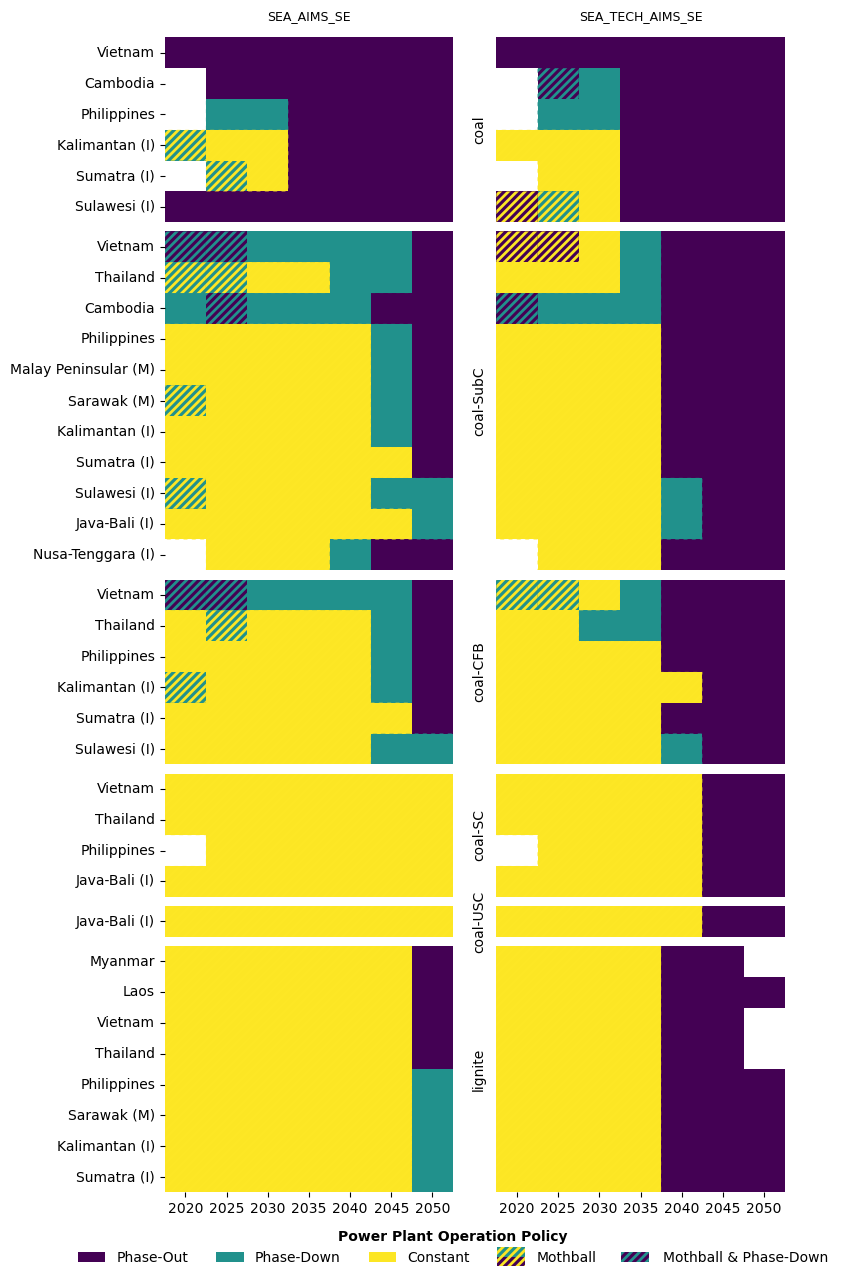

In [60]:
capacity_factor_table_compare(fn_se, "SEA_AIMS_", "SE", fn_se_tech, "SEA_TECH_AIMS_", "SE")

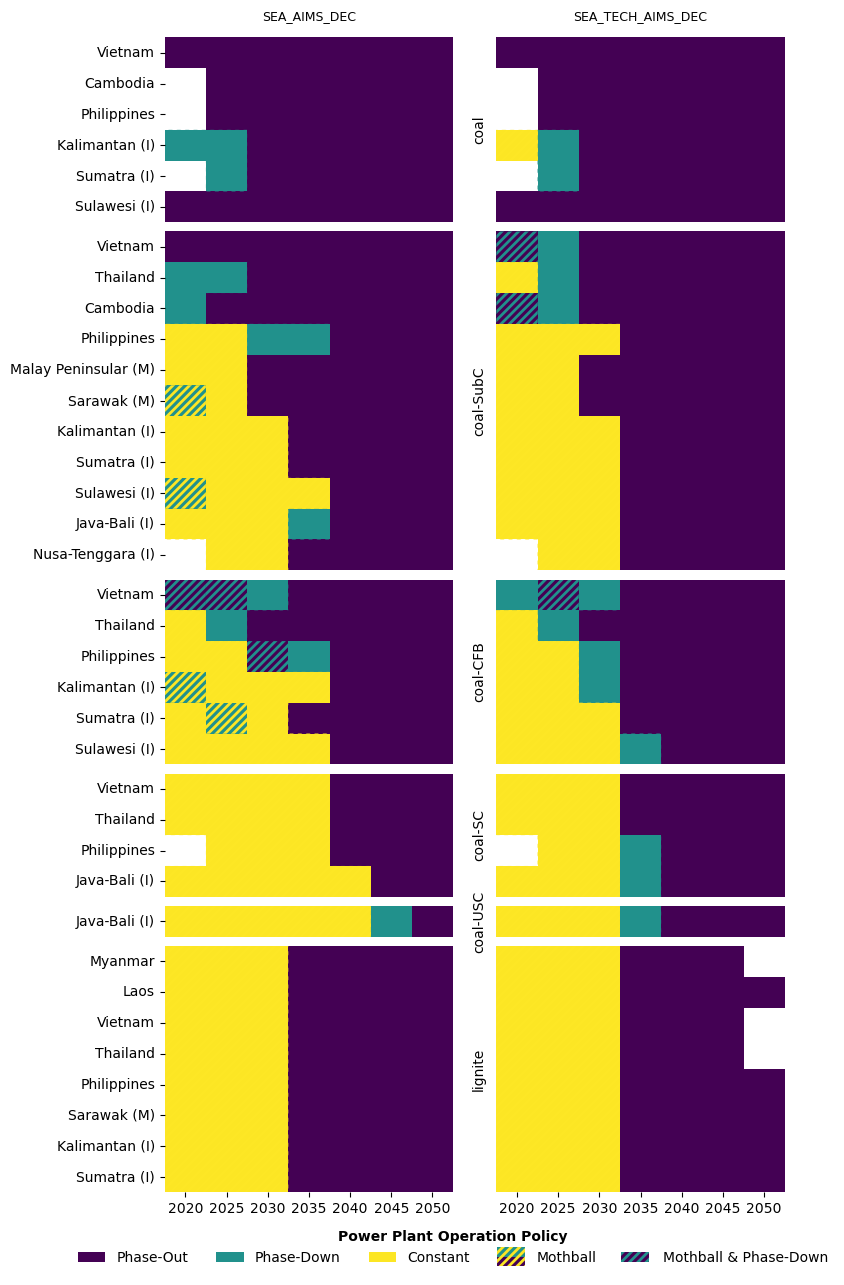

In [62]:
capacity_factor_table_compare(fn_dec, "SEA_AIMS_", "DEC", fn_dec_tech, "SEA_TECH_AIMS_", "DEC")

# Query powerplant based on regional capacity factor

Note: Lignite was not included in the powerplant_technology. It is used all the time except after the year 2040 in stable, and 2035 in dec

In [972]:
coal_dict={"Hard Coal subcritical": "coal-SubC",
           "Hard Coal supercritical": "coal-SC",
           "Hard Coal ultra-supercritical": "coal-USC",
           "Hard Coal CFB": "coal-CFB",
           "Hard Coal": "coal",
           "Lignite" : "lignite"
          }

In [973]:
scenario_PyPSA = "SEA_BAU_"
folder_name = "pypsa-earth"
network_name = "elec"

years = [2020,2025,2030,2035,2040,2045,2050]

fn_elec = {year:pypsa.Network(f"../{folder_name}/networks/{scenario_PyPSA + str(year)}/{network_name}.nc") for year in years} 
fn_ppl = {year:pd.read_csv(f"../{folder_name}/resources/{scenario_PyPSA + str(year)}/powerplants.csv", index_col=0) for year in years}

INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, transformers
INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, transformers
INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, transformers
INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, transformers
INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, transformers
INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, transformers
INFO:pypsa.io:Imported network elec.nc has buses, carriers, generators, lines, links, loads, transformers


# Unused Code

In [ ]:
#gradient mode
def cap_condition(v):
    return round(v,2)

def make_pretty(styler):
    styler.format(cap_condition)
    styler.background_gradient(axis=None, vmin=0, vmax=100, cmap=None)
    return styler

# clear mode
def cap_clear(v):
    if v == 0:
        return "No Capacity"
    elif v == 1:
        return "Phase-Out"
    elif v == 2:
        return "Phase-Down"
    else:
        return "Constant"

def make_clear(styler):
    #styler.set_caption("Weather Conditions")
    styler.format(cap_clear)
    styler.background_gradient(axis=None, vmin=0, vmax=3, cmap=None)
    return styler

    #df_cap_factor = df_cap_factor.groupby(["carrier","country"]).sum()

    #df_style = df_cap_factor.style.pipe(make_pretty)

    #dfi.export(df_cap_factor.style.background_gradient(), "df_style.png", table_conversion="matplotlib")

    #df_to_html = df_cap_factor.style.pipe(make_pretty)
    
    #for year in df_cap_factor.columns:
    #    df_cap_factor[year] = df_cap_factor[year].apply(lambda x: 0 if x == 0 else (1 if 0 < x < 10 else (2 if x < 40 else 3)))
    #display(df_cap_factor.style.pipe(make_clear))

    #df_cap_factor.to_csv(f"phase-out-powerplant/powerplants_phase-out_{name}.csv")

    #for year in df_cap_factor.columns:
    #    df_cap_factor[year] = df_cap_factor[year].apply(lambda x: "No Capacity" if x == 0 else ("Phase-Out" if x == 1 else ("Phase-Down" if x == 2 else "Constant")))

    #df_cap_factor.to_csv("capacity_factor_name.csv")

## Pars out all phase out powerplants

In [997]:
ppl_tech = pd.read_csv("../pypsa-earth/configs/powerplants_technology.csv", index_col="complete_name")
ppl_tech["true_country"] = np.nan
for year in years:
    df_country = pd.DataFrame(index=fn_elec[year].generators.index)

    df_country["gen_code"] = df_country.index
    df_country["gen_code"] = [df_country.loc[i,"gen_code"][1:] if df_country.loc[i,"gen_code"][0] == "C" else np.nan for i in df_country.index]
    df_country["true_country"] = fn_elec[year].generators.bus.map(fn_elec[year].buses.country)

    df_country = df_country[df_country.gen_code.isna() == False]
    df_country["unique_name"] = [fn_ppl[year].loc[int(g),"unique_name"] for g in df_country.gen_code]
    df_country["DateOut"] = [fn_ppl[year].loc[int(g),"DateOut"] for g in df_country.gen_code]
    for i in df_country.index:
        n = df_country.loc[i,"unique_name"]
        if n in ppl_tech.index:
            ppl_tech.loc[n,"true_country"] = df_country.loc[i,"true_country"]
            ppl_tech.loc[n,"DateOut"] = df_country.loc[i,"DateOut"]

inv_longname = {v: k for k, v in country_longname.items()}
inv_coal_dict = {v: k for k, v in coal_dict.items()}

df_matrix_stable = pd.read_csv("phase-out-powerplant/powerplants_phase-out_stable.csv")
df_matrix_stable = df_matrix_stable.query("carrier != 'lignite'")
df_matrix_stable["country"] = [inv_longname[c] for c in df_matrix_stable.country]
df_matrix_stable["carrier"] = [inv_coal_dict[c] for c in df_matrix_stable.carrier]

df_matrix_dec = pd.read_csv("phase-out-powerplant/powerplants_phase-out_dec.csv")
df_matrix_dec = df_matrix_dec.query("carrier != 'lignite'")
df_matrix_dec["country"] = [inv_longname[c] for c in df_matrix_dec.country]
df_matrix_dec["carrier"] = [inv_coal_dict[c] for c in df_matrix_dec.carrier]

In [1019]:
phase_down_ppl_stable = {2020:{"Han Seng 265 2067",
                               "Sihanoukville Cel 250 2059"
                              },
                         2025:{"Han Seng 265 2067",
                               "Sihanoukville Cel 250 2059"
                              },
                         2030:{"Han Seng 265 2067",
                               "Sihanoukville Cel 250 2059"
                              },
                         2035:{"Map Ta Phut Blcp 1434 2051",
                               "Cao Ngan 115 2051"
                              },
                         2040:{"Rembang 630 2056","Indramayu 990 2055","Banten Labuan 600 2054","Cilacap Sumber 2260 2051",
                               "Sumsel 600 2068","Bengkulu 200 2064","Sumsel 300 2061","Banjarsari 220 2060","Keban Agung 270 2060",
                               "Lampung Sebalang 200 2060","Pangkalan Susu 840 2059","Bangka Baru 60 2059","Nagan Raya 620 2058",
                               "Tanjung Kasam 130 2057","Tarahan 200 2052","Ombilin 200 2041"
                              }}

phase_down_ppl_dec = {2020:set(),
                      2025:set(),
                      2030:{"Sec 118 2061","Concepcion 270 2061","Davao Therma South 300 2060",
                            "Toledo Corp Sangi Sta 88 2054","Limay 600 2038","Nong Son 30 2059",
                            "Vung Ang 2400 2059","Nghi Son 1920 2058","Formosa Dong Nai 310 2056",
                            "Hai Phong 1200 2054","Quang Ninh 1200 2054","Cao Ngan 115 2051"
                           },
                      2035:{"Jawa 1982 2064"
                           },
                      2040:set()}


ppl_tech_raw = pd.read_csv("../pypsa-earth/configs/powerplants_technology.csv", index_col="complete_name")

# For stable emissions
for year in ["2020","2025","2030","2035","2040"]:
    ppl_tech_clean = ppl_tech_raw.copy(deep=True)

    # Listing all of the removed powerplants (Stable)
    for i in df_matrix_stable.index:
        if df_matrix_stable.loc[i,year] == 0:
            country = df_matrix_stable.loc[i,"country"]
            carrier = df_matrix_stable.loc[i,"carrier"]
            print(f"removing all {carrier} in {country} for the year {year}")
            phase_out_ppl = ppl_tech.loc[ppl_tech.Fueltype == carrier].loc[ppl_tech.true_country == country].loc[ppl_tech.Captive.isnull()].index
            ppl_tech_clean.loc[phase_out_ppl,"Captive"] = "Phase-out"
            if 'Cao Ngan 115 2051' in phase_out_ppl:
                print("yes")

    ppl_tech_clean.loc[list(phase_down_ppl_stable[int(year)]),"Captive"] = "Phase-down"
    ppl_tech_clean.to_csv(f"../pypsa-earth/resources/SEA_opt_stable_BAU_{year}/powerplants_technology.csv")


# For deep decarbonization
for year in ["2020","2025","2030","2035","2040"]:
    ppl_tech_clean = ppl_tech_raw.copy(deep=True)

    # Listing all of the removed powerplants (Stable)
    for i in df_matrix_dec.index:
        if df_matrix_dec.loc[i,year] == 0:
            country = df_matrix_dec.loc[i,"country"]
            carrier = df_matrix_dec.loc[i,"carrier"]
            print(f"removing all {carrier} in {country} for the year {year}")
            phase_out_ppl = ppl_tech.loc[ppl_tech.Fueltype == carrier].loc[ppl_tech.true_country == country].loc[ppl_tech.Captive.isnull()].index
            ppl_tech_clean.loc[phase_out_ppl,"Captive"] = "Phase-out"


    ppl_tech_clean.loc[list(phase_down_ppl_dec[int(year)]),"Captive"] = "Phase-down"
    ppl_tech_clean.to_csv(f"../pypsa-earth/resources/SEA_opt_dec_BAU_{year}/powerplants_technology.csv")



removing all Hard Coal in KH for the year 2020
removing all Hard Coal in VN for the year 2020
removing all Hard Coal in KH for the year 2025
removing all Hard Coal in PH for the year 2025
removing all Hard Coal in VN for the year 2025
removing all Hard Coal in KH for the year 2030
removing all Hard Coal in PH for the year 2030
removing all Hard Coal in VN for the year 2030
removing all Hard Coal in KH for the year 2035
removing all Hard Coal subcritical in KH for the year 2035
removing all Hard Coal in Kalimantan/ID for the year 2035
removing all Hard Coal in PH for the year 2035
removing all Hard Coal in Sulawesi/ID for the year 2035
removing all Hard Coal in Sumatra/ID for the year 2035
removing all Hard Coal in VN for the year 2035
removing all Hard Coal CFB in VN for the year 2035
removing all Hard Coal in KH for the year 2040
removing all Hard Coal subcritical in KH for the year 2040
removing all Hard Coal in Kalimantan/ID for the year 2040
removing all Hard Coal subcritical in Ka

# Testing if no powerplant went missing

In [ ]:
for i in ppl_tech.index:
    country = ppl_tech.loc[i,"Country"]
    t_country = ppl_tech.loc[i,"true_country"]
    if country != t_country:
        print(f"{country} -> {t_country}")
        if type(t_country) == float:
            captive = ppl_tech.loc[i,"Captive"]
            if type(captive) == str:
                print("its captive")
            else:
                print("===========================Watch Out==============================")

# Iteration:

In [550]:
def get_opt_capacity(n, target, country, carrier):
    step = 0.1
    factor = 1
    limit = 0.1
    
    while True:
        print(f"factor: {factor}")
        
        df_gen = n.generators
        df_gen["country"] = n.generators.bus.map(n.buses.country)
        df_gen = df_gen.query("country in @country")
        df_gen = df_gen.query("carrier in @carrier")
        
        p_nom_opt = df_gen.p_nom_opt.sum()
        p_nom_target = p_nom_opt * factor
        
        df_p = n.generators_t.p.T
        df_p["country"] = n.generators.bus.map(n.buses.country)
        df_p = df_p.query("country in @country")
        df_p["carrier"] = n.generators.carrier
        df_p = df_p.query("carrier in @carrier")
        df_p = df_p.drop(["country","carrier"], axis=1).T
        
        p = df_p.T.sum().T.clip(upper=p_nom_target)
        
        cap_factor = p/p_nom_target

        cap_factor = cap_factor.mean()*100

        if cap_factor > target:
            return p_nom_target
        else:
            factor -= step
        
        if factor <= limit:
            return "infeasable"

        print(f"capacity factor: {cap_factor}")

In [964]:
carrier_focus = "coal-SubC"
country_focus = "KH"
year = 2030

get_opt_capacity(fn_bau[year], 40, country_focus, carrier_focus)

factor: 1
capacity factor: 36.38134919308817
factor: 0.9
capacity factor: 37.257784023780886
factor: 0.8
capacity factor: 38.169734560907514
factor: 0.7000000000000001
capacity factor: 39.2270872988411
factor: 0.6000000000000001


972.0000000000001

## Take powerplant division:

In [965]:
ppl_tech_2 = ppl_tech.copy(deep=True)

ppl_tech_2["carrier"] = [coal_dict[ppl] for ppl in ppl_tech.Fueltype]

ppl_tech_2 = ppl_tech_2.query("true_country == @country_focus & carrier in @carrier_focus").loc[:,["Capacity","DateOut"]]
ppl_tech_2 = ppl_tech_2.sort_values("DateOut", ascending=False)
ppl_tech_2 = ppl_tech_2.query("DateOut >= @year")

ppl_tech_2["Capacity_cum"] = ppl_tech_2["Capacity"].rolling(min_periods=1, window=100).sum()

pd.set_option('display.max_rows', None)
display(ppl_tech_2)
pd.set_option('display.max_rows', 10)

,Capacity,DateOut,Capacity_cum
complete_name,,,
Han Seng 265 2067,265.0,2067.0,265.0
Sihanoukville Ciidg 1105 2059,1105.0,2059.0,1370.0
Sihanoukville Cel 250 2059,250.0,2059.0,1620.0


In [953]:
4691.0 - 1434

3257.0

# Visualization

capacity factor: 39.438733193780635
1105.0


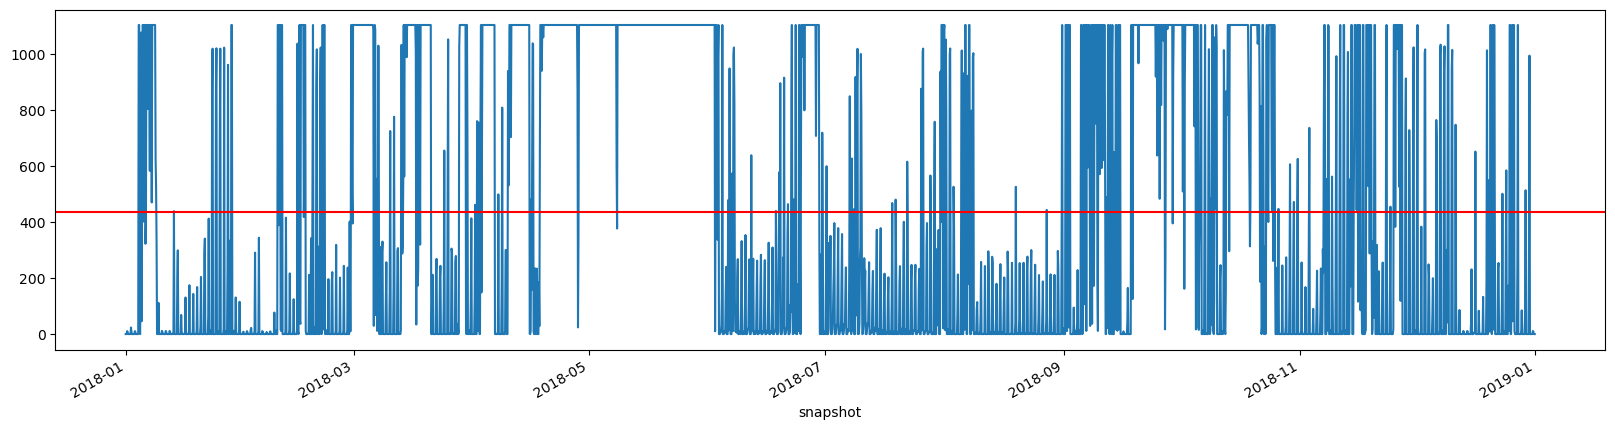

In [966]:
p_nom_target = 1105.0
n = fn_bau[year]

df_gen = n.generators
df_gen["country"] = n.generators.bus.map(n.buses.country)
df_gen = df_gen.query("country in @country_focus")
df_gen = df_gen.query("carrier in @carrier_focus")

p_nom_opt = df_gen.p_nom_opt.sum()

if not p_nom_target:
    p_nom_target = p_nom_opt

df_p = n.generators_t.p.T
df_p["country"] = n.generators.bus.map(n.buses.country)
df_p = df_p.query("country in @country_focus")
df_p["carrier"] = n.generators.carrier
df_p = df_p.query("carrier in @carrier_focus")
df_p = df_p.drop(["country","carrier"], axis=1).T

p = df_p.T.sum().T.clip(upper=p_nom_target)

cap_factor = p/p_nom_target

fig, ax = plt.subplots(figsize=(20,5))

p.plot(ax=ax)
print("capacity factor: " + str(cap_factor.mean()*100))
print(p_nom_target)

ax.axhline(y=cap_factor.mean()*p_nom_target, color='r', linestyle='-')

## Results in trimming

In [ ]:
n.generators_t.p

capacity factor: nan
Generator
Sulawesi/ID1 7 coal-CFB    60.0
Name: p_nom_opt, dtype: float64


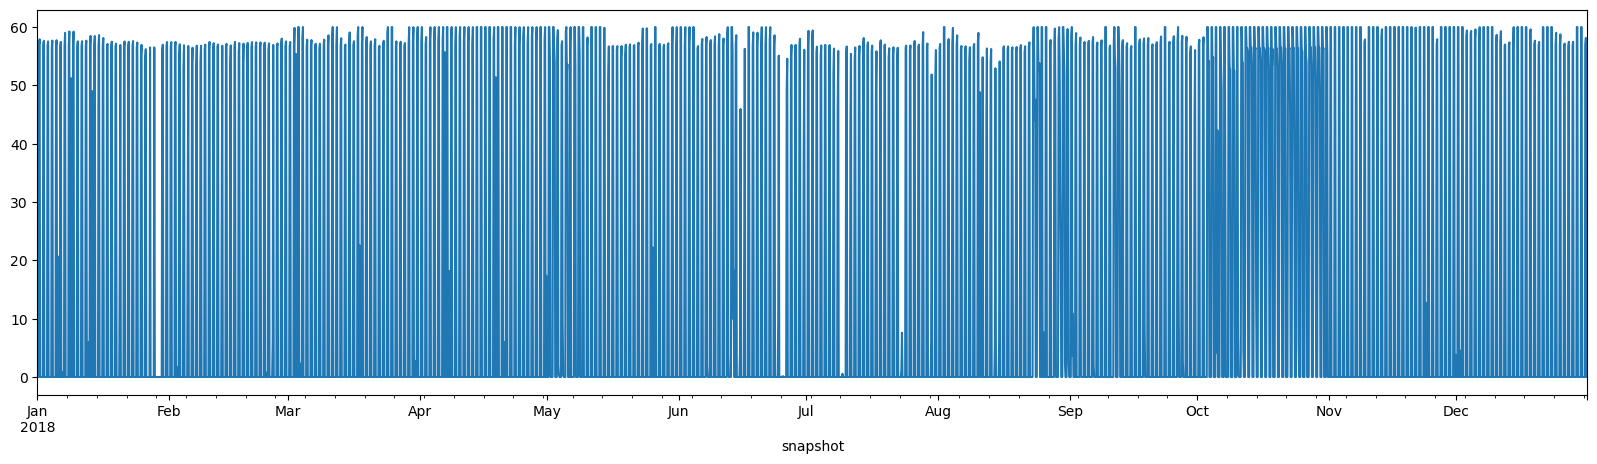

In [395]:
carrier_focus = "coal-CFB"
country_focus = "Sulawesi/ID"

n = fn_bau[2040]

df_gen = n.generators
df_gen["country"] = n.generators.bus.map(n.buses.country)
df_gen_index = df_gen.query("carrier in @carrier_focus & country in @country_focus").index


ppl_focus = df_gen_index[0]

p_nom_opt = n.generators.loc[[ppl_focus],"p_nom_opt"]
p = n.generators_t.p[ppl_focus]
cap_factor = p.sum()/p_nom_opt

fig, ax = plt.subplots(figsize=(20,5))

p.plot(ax=ax)
print("capacity factor: " + str(cap_factor*100))
print(p_nom_opt)

#ax.axhline(y=cap_factor.mean()*p_nom_opt, color='r', linestyle='-')

In [397]:
p/p_nom_opt

2018-01-01 00:00:00       NaN
2018-01-01 03:00:00       NaN
2018-01-01 06:00:00       NaN
2018-01-01 09:00:00       NaN
2018-01-01 12:00:00       NaN
                           ..
2018-12-31 12:00:00       NaN
2018-12-31 15:00:00       NaN
2018-12-31 18:00:00       NaN
2018-12-31 21:00:00       NaN
Sulawesi/ID1 7 coal-CFB   NaN
Length: 2921, dtype: float64

capacity factor: 60.66796905456532
2583.75


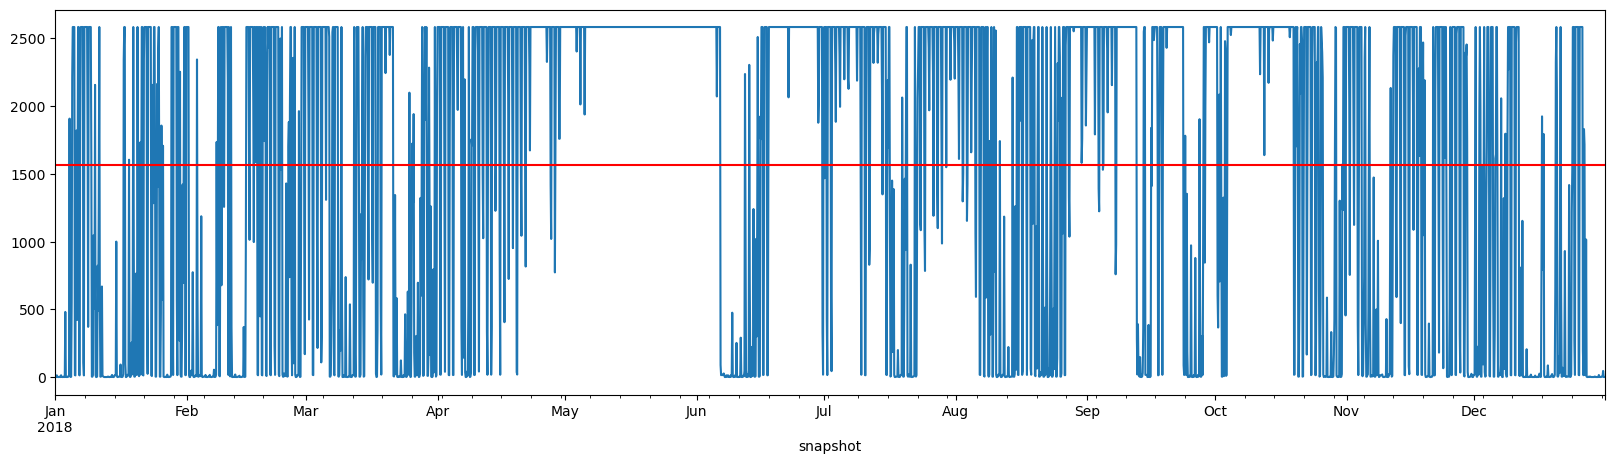

In [186]:
itterate = 0.65

p_nom_opt = n.generators.loc[ppl_focus,"p_nom_opt"]
p = n.generators_t.p[ppl_focus]

p_nom_target = itterate * p_nom_opt

#p_nom_target = 1
p_clip = p.clip(upper=p_nom_target)
cap_factor_new = p_clip/p_nom_target

fig, ax = plt.subplots(figsize=(20,5))

p_clip.plot(ax=ax)
print("capacity factor: " + str(cap_factor_new.mean()*100))
print(p_nom_target)

ax.axhline(y=cap_factor_new.mean()*p_nom_target, color='r', linestyle='-')
#cap_factor = p/p_nom_opt


In [104]:
n.generators_t.p[ppl_focus].sum()/(len(n.snapshots)*n.generators.loc[ppl_focus,"p_nom_opt"])

0.6745762649206084

In [91]:
scenarios = ["SEA_ERA5_2011_INT_", "SEA_ERA5_2011_BAU_", "SEA_ERA5_2011_EXT_"]
folder_name = "pypsa-earth"
network_name = "elec_s_200_ec_lcopt_Co2L0.029752-3H"

year = 2050

fn = {scenario:pypsa.Network(f"../{folder_name}/results/{scenario}{year}/networks/{network_name}.nc") for scenario in scenarios} 

INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.029752-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.029752-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.io:Imported network elec_s_200_ec_lcopt_Co2L0.029752-3H.nc has buses, carriers, generators, global_constraints, lines, links, loads, stores


In [92]:
n = fn["SEA_ERA5_2011_BAU_"]

8.950807217633082


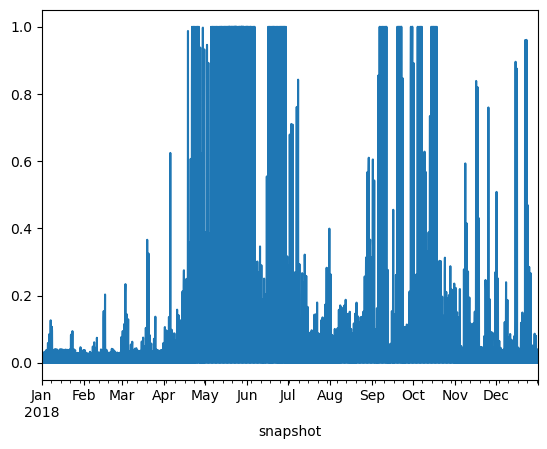

In [398]:
carrier_focus = "coal-SubC"
country_focus = "Kalimantan/ID"

df_gen = n.generators
df_gen["country"] = n.generators.bus.map(n.buses.country)
df_gen_index = df_gen.query("carrier in @carrier_focus & country in @country_focus").index

df_gen_index

ppl_focus = df_gen_index[0]

(n.generators_t.p[ppl_focus]/n.generators.loc[ppl_focus,"p_nom"]).plot()
cap_factor = n.generators_t.p[ppl_focus].sum()/(len(n.snapshots)*n.generators.loc[ppl_focus,"p_nom"])*100
print(cap_factor)

# Recreating the marketability (but with more accuracy)

In [30]:
n = n_test#fn[2040]

#busname = n.buses.query("carrier in ['AC','DC']").index
#marginal_price = n.buses_t.marginal_price.loc[:,busname]

generators = n.generators
generators["revenue"] = [n.snapshot_weightings.generators @ (n.generators_t.p[g] * n.buses_t.marginal_price[n.generators.loc[g,"bus"]]) for g in n.generators.index]
generators["operational_expenditure"] = [n.snapshot_weightings.generators @ (n.generators_t.p[g] * n.generators.loc[g,"marginal_cost"]) for g in n.generators.index]
generators["capital_expenditure"] = n.generators.p_nom_opt * n.generators.capital_cost
generators["capacity_factor"] = [n.snapshot_weightings.generators @ n.generators_t.p[g] / (len(n.snapshots) * 3 * n.generators.loc[g,"p_nom_opt"]) for g in n.generators.index]

In [218]:
n.generators.p_nom_extendable.mask(n.generators.carrier.isin(phased_out), True, inplace=True)
n.generators.p_nom_max.mask(n.generators.carrier.isin(phased_out), n.generators.p_nom_min, inplace=True)
n.generators.p_nom_min.mask(n.generators.carrier.isin(phased_out), 0, inplace=True)
n.generators.p_nom.mask(n.generators.carrier.isin(phased_out), 0, inplace=True)

In [245]:
n.generators.loc[n.generators.carrier.isin(phased_out),"p_nom_extendable"] = True
n.generators.loc[n.generators.carrier.isin(phased_out),"p_nom_max"] = n.generators.p_nom_min
n.generators.loc[n.generators.carrier.isin(phased_out),"p_nom_min"] = 0
n.generators.loc[n.generators.carrier.isin(phased_out),"p_nom"] = 0

In [222]:
if phased_out:
    print("yes")

yes
